In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import json
import pathlib
import numpy as np
import pandas as pd
import html
from fastai.text import *

# Data Preparation

In [3]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH = pathlib.Path("lm-data/wiki_extr/id")

In [4]:
LM_PATH=Path('lm-data/id/lm/')
LM_PATH.mkdir(parents=True, exist_ok=True)

In [5]:
LANG_FILENAMES = [str(f) for f in PATH.rglob("*/wiki_*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

517


['lm-data/wiki_extr/id/AA/wiki_00',
 'lm-data/wiki_extr/id/AA/wiki_01',
 'lm-data/wiki_extr/id/AA/wiki_02',
 'lm-data/wiki_extr/id/AA/wiki_03',
 'lm-data/wiki_extr/id/AA/wiki_04']

In [6]:
LANG_TEXT = []
for fn in tqdm(LANG_FILENAMES):
    for line in open(fn, encoding='utf8'):
        LANG_TEXT.append(json.loads(line))
        
LANG_TEXT = pd.DataFrame(LANG_TEXT)

100%|██████████| 517/517 [00:04<00:00, 122.78it/s]


In [7]:
LANG_TEXT.head()

,id,text,title,url
0,1,Asam deoksiribonukleat\n\nAsam deoksiribonukle...,Asam deoksiribonukleat,https://id.wikipedia.org/wiki?curid=1
1,3,Anwar Sadat\n\nJenderal Besar Mohammed Anwar A...,Anwar Sadat,https://id.wikipedia.org/wiki?curid=3
2,4,Azhar Mansor\n\nDatuk Azhar Mansor adalah oran...,Azhar Mansor,https://id.wikipedia.org/wiki?curid=4
3,5,Arkeologi\n\nArkeologi atau ilmu kepurbakalaan...,Arkeologi,https://id.wikipedia.org/wiki?curid=5
4,6,Antropologi\n\nAntropologi adalah ilmu tentang...,Antropologi,https://id.wikipedia.org/wiki?curid=6


In [8]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_Indonesia_Corpus.csv", index=False)

In [9]:
# Getting rid of the title name in the text field
def split_title_from_text(text):
    words = text.split("\n\n")
    if len(words) >= 2:
        return ''.join(words[1:])
    else:
        return ''.join(words)
    
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: split_title_from_text(x))

In [10]:
LANG_TEXT.head()

,id,text,title,url
0,1,"Asam deoksiribonukleat, lebih dikenal dengan s...",Asam deoksiribonukleat,https://id.wikipedia.org/wiki?curid=1
1,3,Jenderal Besar Mohammed Anwar Al Sadat (; ) ad...,Anwar Sadat,https://id.wikipedia.org/wiki?curid=3
2,4,Datuk Azhar Mansor adalah orang Malaysia perta...,Azhar Mansor,https://id.wikipedia.org/wiki?curid=4
3,5,Arkeologi atau ilmu kepurbakalaan berasal dari...,Arkeologi,https://id.wikipedia.org/wiki?curid=5
4,6,Antropologi adalah ilmu tentang manusia. Antro...,Antropologi,https://id.wikipedia.org/wiki?curid=6


In [11]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_Indonesia_Corpus2.csv", header=None, index=False)

Sorting the articles by length and keeping the first million (this is actually not necessary for indonesian wiki since it has less than 450k articles in 2018).

In [13]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Indonesia_Corpus2.csv")

In [14]:
LANG_TEXT = LANG_TEXT.assign(length = 0)
LANG_TEXT.columns = ['id', 'text', 'title', 'url', 'length']
LANG_TEXT = LANG_TEXT.assign(labels = 0).pipe(lambda x: x[['labels', 'text', 'length']])

In [15]:
LANG_TEXT.head()

,labels,text,length
0,0,Jenderal Besar Mohammed Anwar Al Sadat (; ) ad...,0
1,0,Datuk Azhar Mansor adalah orang Malaysia perta...,0
2,0,Arkeologi atau ilmu kepurbakalaan berasal dari...,0
3,0,Antropologi adalah ilmu tentang manusia. Antro...,0
4,0,"Analisis leksikal (bahasa Inggris: ""lexical an...",0


In [16]:
LANG_TEXT['length'] = LANG_TEXT['text'].str.len()
LANG_TEXT = LANG_TEXT.sort_values(by=['length'], ascending=False)

In [17]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_Indonesia_Corpus2.csv", header=False, index=False)

In [18]:
len(LANG_TEXT)

439608

In [19]:
LANG_TEXT = LANG_TEXT[LANG_TEXT['length'] > 100]

In [20]:
LANG_TEXT = LANG_TEXT.iloc[0:1000000]

In [21]:
len(LANG_TEXT)

400256

# Some statistics of Indonesia Wikipedia

### Number of documents

In [22]:
print(LANG_TEXT['text'][:5])
LANG_TEXT.shape

188440    Technische Hoogeschool te Bandoeng biasa disin...
114691    Kemilau Cinta Kamila atau biasa disingkat KCK ...
1369      Republik Chili (), kadang-kadang dieja sebagai...
4339      Josef Vissarionovich Stalin () adalah pemimpin...
5078      Perang Dunia I (PDI) adalah sebuah perang glob...
Name: text, dtype: object


(400256, 3)

### Number of words in all the documents

In [23]:
LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

63094666

### Number of unique tokens across documents

In [24]:
len(set(''.join(LANG_TEXT['text'].values).split(" ")))

3575199

## Tokenize

In [25]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [26]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts), lang='xx') # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [27]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Indonesia_Corpus2.csv", header=None)#, chunksize=5000)

In [28]:
print(LANG_TEXT.head())
LANG_TEXT.shape

   0                                                  1         2
0  0  Technische Hoogeschool te Bandoeng biasa disin...  159917.0
1  0  Kemilau Cinta Kamila atau biasa disingkat KCK ...  141607.0
2  0  Republik Chili (), kadang-kadang dieja sebagai...  133775.0
3  0  Josef Vissarionovich Stalin () adalah pemimpin...  129387.0
4  0  Perang Dunia I (PDI) adalah sebuah perang glob...  127190.0


(439608, 3)

In [29]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    LANG_TEXT, test_size=0.1) # split the data into train and validation sets

In [30]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts)) # generate a random ordering
val_idx = np.random.permutation(len(val_texts))

df_trn = trn_texts.iloc[trn_idx,:] # sort things randomly
df_val = val_texts.iloc[val_idx,:] # sort things randomly

df_trn.columns = ['labels', 'text', 'length']
df_val.columns = ['labels', 'text', 'length']

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False) # saving the data in our new format to disk

In [31]:
chunksize = 10000
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [32]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0
1
2
3
4


In [33]:
# create a tmp directory to store the upcoming numpy arrays
(LM_PATH/'tmp').mkdir(exist_ok=True)

# save the train and validation tokens in the tmp directories
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [34]:
print("Trn:", tok_trn[:2], "\n")

Trn: [['\n', 'xbos', 'xfld', '1', 'kutambaru', 'merupakan', 'salah', 'satu', 'desa', 'yang', 'ada', 'di', 'kecamatan', 'tiganderket', ',', 'kabupaten', 'karo', ',', 'provinsi', 'sumatera', 'utara', ',', 'indonesia', '.', '\n ', 'xfld', '1', '123.0'], ['\n', 'xbos', 'xfld', '1', 'sifaka', 'perrier', '(', '"', 'propithecus', 'perrieri', '"', ')', 'adalah', 'seekor', 'lemur', 'endemik', 'madagaskar', '.', 'hewan', 'tersebut', 'dulunya', 'dianggap', 'sebagai', 'subspesies', 'diademed', 'sifakareferensi', '.', '\n \n ', 'xfld', '1', '159.0']] 



In [35]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [36]:
# Identify the most common tokens and numericalizing the text
freq = Counter(p for o in tok_trn for p in o) 
freq.most_common(25)

[(',', 3671684),
 ('.', 2873347),
 ('dan', 1679845),
 ('yang', 1671563),
 ('di', 1252995),
 ('"', 1229125),
 ('\n', 892952),
 ('1', 846001),
 ('-', 820121),
 ('dari', 814579),
 ('xfld', 791294),
 ('pada', 769197),
 ('ini', 753785),
 ('(', 635694),
 ('dengan', 629569),
 ('adalah', 618717),
 (')', 605809),
 ('t_up', 525503),
 ('untuk', 513739),
 ('dalam', 511064),
 ('tahun', 413582),
 ('xbos', 395647),
 ('oleh', 342616),
 ('sebagai', 330319),
 ('juga', 296394)]

In [37]:
# Truncating our vocab to ignore the rare words
max_vocab = 60000
min_freq = 5

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
itos.insert(0, '_pad_') # 
itos.insert(0, '_unk_') # itos is the list of all the strings in the vocab

In [38]:
# creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [39]:
# creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [40]:
# saving our indexed representation of our dataset to disk
# we also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [41]:
# Loading the indexed representation of our dataset from disk
# we also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [42]:
# checking vocabulary size
vs=len(itos)
vs,len(trn_lm)

(60002, 395647)

# Model Setup

In [43]:
# ! wget -nH -r -np http://files.fast.ai/models/wt103/
# mv models/ {LM_PATH}

In [44]:
em_sz,nh,nl = 400,1150,3

PRE_PATH = LM_PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

# itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb')) # mapping the itos from wiki to our own mapping
# stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [ ]:
# we train from scratch so these are unused
# wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

# enc_wgts = to_np(wgts['0.encoder.weight'])
# row_m = enc_wgts.mean(0)

# wgts['0.encoder.weight'] = T(new_w)
# wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
# wgts['1.decoder.weight'] = T(np.copy(new_w))

# Language Model

In [45]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [46]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [47]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7 # if you're overfitting, increase this. Underfitting? decrease this.

In [48]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.clip = 0.2
learner.unfreeze()

In [49]:
lr=1e-3
lrs = lr

In [ ]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1) # last layer is the embedding weights

In [ ]:
learner.save('lm_indonesia_v2')

In [ ]:
learner.load('lm_indonesia_v2')

In [ ]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 89%|████████▉ | 17416/19547 [1:08:16<08:21,  4.25it/s, loss=4.58]

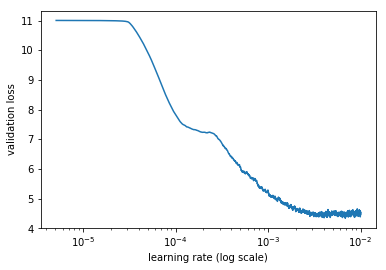

In [22]:
learner.sched.plot()

In [51]:
lrs = 4e-3

In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                         
    0      4.22164    4.167298   0.323482  
    1      4.230995   4.135004   0.32745                          
    2      4.161235   4.042909   0.336713                         
    3      4.086843   3.997987   0.341134                         
    4      4.101865   3.957439   0.345047                         
    5      4.066114   3.929912   0.347438                         
    6      4.013648   3.90214    0.349762                         
    7      3.985552   3.878478   0.352015                         
    8      3.974462   3.857443   0.354098                         
    9      3.953277   3.836368   0.35588                          
    10     3.967763   3.81269    0.358301                         
    11     3.961732   3.795156   0.360286                         
    12     3.905945   3.777561   0.361978                         
    13     3.941869   3.75649    0.364426                         
    14     3.89807

[array([3.73653]), 0.3667913729591029]

In [26]:
learner.save('lm_indonesia_final')

In [27]:
learner.save_encoder('lm_indonesia_final_enc')

### Generate text

In [50]:
learner.load("lm_indonesia_final")

KeyError: 'unexpected key "encoder.weight" in state_dict'

In [29]:
m = learner.model
m.eval()
m[0].bs = 1

## Inference

In [30]:
sen = """saya ucapkan terima"""

In [31]:
idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
idxs

array([[  906, 29687,  4441]])

In [32]:
VV(idxs)

Variable containing:
   906  29687   4441
[torch.cuda.LongTensor of size 1x3 (GPU 0)]

In [33]:
probs = learner.model(VV(idxs))

In [35]:
learner.model

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002)
    (dropout): LockedDropout(
    )
  )
)

In [36]:
probs[0].shape, [x.shape for x in probs[1]], [x.shape for x in probs[2]]

(torch.Size([3, 60002]),
 [torch.Size([1, 3, 1150]), torch.Size([1, 3, 1150]), torch.Size([1, 3, 400])],
 [torch.Size([1, 3, 1150]), torch.Size([1, 3, 1150]), torch.Size([1, 3, 400])])

In [ ]:
# probs[0] is most likely the output vector

### Arvind's answer

In [37]:
def get_next(inp, pos):
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    p = m(VV(idxs))
    top = torch.topk(p[0][-1], 10)
    i = top[1].data[pos]
    try:
        r = itos[i]
    except:
        r = "oor"
    return r

In [38]:
def get_next_n(inp, n, pos):
    res = inp
    for i in range(n):
        c = get_next_4(inp, pos)
        res = res + " " + c
        inp = inp.strip().split(" ") + [c]  
        inp = ' '.join(inp)
        
    return res

In [42]:
m = learner.model
m.eval()
m[0].bs = 1

In [52]:
string = """masak sayur"""
for i in range(10):
    print(get_next_n(string, 10, i))

masak sayur - _unk_ , dan _unk_ , dan _unk_ , dan
masak sayur , yang telah menjadi " . _unk_ _unk_ _unk_ _unk_
masak sayur dan juga _unk_ . pada _unk_ . pada _unk_ .
masak sayur _unk_ ( t_up the world 's " ( t_up the
masak sayur yang pertama kalinya pada waktu itu . 
  pada waktu
masak sayur . di antara . di antara . di antara .
masak sayur di luar dari para pemain di luar dari para pemain
masak sayur ( dari semua ini telah melakukan aktivitas ekonomi dari semua
masak sayur atau sebagai orang dari . dengan tujuan utamanya _unk_ adalah
masak sayur " adalah bagian utara dengan demikian karena telah berhasil dan


In [47]:
sen = """masak sayur"""
for i in range(10):
    print(get_next_n(sen, 10, i))

kemarin ibu saya masak sayur - _unk_ , dan _unk_ , dan _unk_ , dan
kemarin ibu saya masak sayur , yang telah menjadi " . _unk_ _unk_ _unk_ _unk_
kemarin ibu saya masak sayur dan juga _unk_ . pada _unk_ . pada _unk_ .
kemarin ibu saya masak sayur _unk_ ( t_up the world 's " ( t_up the
kemarin ibu saya masak sayur yang pertama kalinya pada waktu itu . 
  pada waktu
kemarin ibu saya masak sayur . di antara . di antara . di antara .
kemarin ibu saya masak sayur di luar dari para pemain di luar dari para pemain
kemarin ibu saya masak sayur ( dari semua ini telah melakukan aktivitas ekonomi dari semua
kemarin ibu saya masak sayur atau sebagai orang dari . dengan tujuan utamanya _unk_ adalah
kemarin ibu saya masak sayur " adalah bagian utara dengan demikian karena telah berhasil dan
